In [1]:
import numpy as np
from scipy.optimize import minimize,fsolve
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
%matplotlib inline
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.api import Poisson
from scipy import stats
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col

# Estimacion de Máxima Verosimilitud 

### Distribución Normal

Los [datos](https://seattlecentral.edu/qelp/sets/059/059.html) provienen de un experimento de Mercer and Hall sobre el rendimiento fanegas de trigo por unidad de tierra  Rothamsted Experimental Station en Gran Bretaña. Los datos siguen una distribución normal, por lo que buscamos obtener los estimadores de máxima verosmilitud. 

In [3]:
global data
data=np.loadtxt('wheat_yield.txt')


Al graficar el hsitograma de frecuencias se observa que la distribución tiene forma de una normal.

Text(0.5, 0, 'Fanegas de trigo por unidad de tierra')

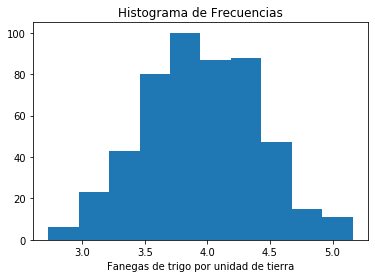

In [4]:
plt.hist(data)
plt.title('Histograma de Frecuencias')
plt.xlabel('Fanegas de trigo por unidad de tierra')

La función de log-verosimilitud asociada a una ditribución normal. Debido a que se plantea un problema de minimización, el resultado es multiplicado por -1.

In [5]:
def normal_loglikelihood(params,*args):
    mu = params[0]
    sigma = params[1]
    x = data
    n=len(data)
    
    loglikelihood=-(n/2)*np.log(2*np.pi)-(n/2)*np.log(sigma**2)-(1/(2*sigma**2))*np.sum((x-mu)**2)
    
    return -1*loglikelihood


In [6]:
x1_grid=np.linspace(2,6,1000)
x2_grid=np.linspace(.1,1.5,1000)
X1, X2 = np.meshgrid(x1_grid, x2_grid)
positions = np.vstack([X1.ravel(), X2.ravel()]).T
ll_eval=np.array([np.log(normal_loglikelihood(i,data)) for i in positions])

In [7]:
ll_eval=ll_eval.reshape(1000,1000)

Text(0, 0.5, 'sigma')

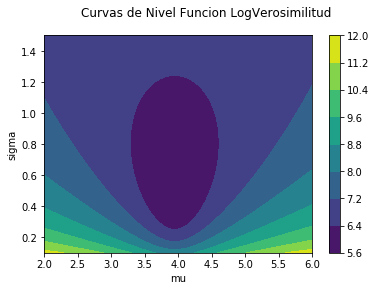

In [8]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X1, X2, ll_eval)
fig.colorbar(cp) 
fig.suptitle('Curvas de Nivel Funcion LogVerosimilitud')
ax.set_xlabel('mu')
ax.set_ylabel('sigma')

En la grafica anterior, se realiza un ajuste des escala aplicando una transformacion logarítmica a la función de log-verosimilitud. Esta es una transformación monótona por lo que la ubicación del punto máximo no se ve afectado. 

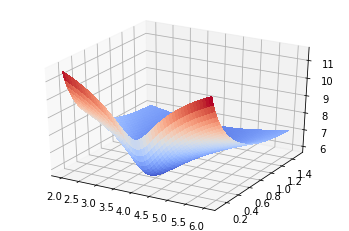

In [9]:

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, ll_eval, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

Para poder calcular el mínimo del negativo de la función logverosimilitud, calcularmos el gradiente que nos dictará la dirección de descenso. 

In [10]:
def gradient_normal_loglike(params,*args):
    mu = params[0]
    sigma = params[1]
    x=data
    n=len(data)
    dmu= (1/(sigma**2))*np.sum(x-mu)
    dsigma=-(n/2)*((2*sigma)/sigma**2)+(1/sigma**3)*np.sum((x-mu)**2)
    return -1*np.array([dmu,dsigma])


El el algoritmo descenso en gradiente toma una paso en el negativo de la dirección del gradiente. El tamaño de paso está ajustado por con coeficiente, en este caso .0001. Existen 2 criterios de paro, un máximo número de iteraciones y diferencia entre la estimación de la iteración $k+1$ y $k$.

In [11]:
x=np.array([1,1])
def gradient_descent(x,gradient,tol=.0001,maxiter=10000,step_size=.0001):
    x_old=x+10
    i=0
    points=list()
    while ((np.linalg.norm(x-x_old)>=tol)):
        if i==1000:
            break
        points.append(x)
        x_old=x
        x=x-step_size*gradient(x)
        i+=1
    return x, points

In [12]:
x,points=gradient_descent(x,gradient_normal_loglike)

Se grafica la trayectoria de descenso hasta llegar al mínimo de la función. 

Text(0, 0.5, 'sigma')

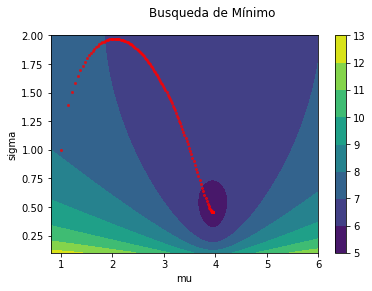

In [13]:
x1_grid=np.linspace(.8,6,1000)
x2_grid=np.linspace(.1,2,1000)
X1, X2 = np.meshgrid(x1_grid, x2_grid)
positions = np.vstack([X1.ravel(), X2.ravel()]).T
ll_eval=np.array([np.log(normal_loglikelihood(i,data)) for i in positions])
ll_eval=ll_eval.reshape(1000,1000)


fig,ax=plt.subplots(1,1)
cp = ax.contourf(X1, X2, ll_eval)



for i in points:
    ax.plot(i[0],i[1], linestyle='--', marker='o', color='red',alpha=.7,markersize=2)
fig.colorbar(cp) 
fig.suptitle('Busqueda de Mínimo')
ax.set_xlabel('mu')
ax.set_ylabel('sigma')


Para contrastar los resultados obtenidos por el algoritmo de descenso en gradiente, se programa la solución analítica al problema y se evalúa con el mismo conjunto de datos.

In [14]:
mean_analytic_normal=lambda x: sum(x)/len(x)

def std_analytic_normal(data, ddof=0):
     n = len(data)
     mean = sum(data) / n
     return np.sqrt(sum((x - mean) ** 2 for x in data) / (n - ddof))

In [15]:
estimators=x
print(estimators)

[3.94832449 0.45782199]


In [16]:
print(mean_analytic_normal(data))
print(std_analytic_normal(data))

3.9486399999999997
0.45782108994671694


El error relativo del estimador de máxima verosimilitud para la media es de: 

In [17]:
(estimators[0]-mean_analytic_normal(data))/abs(mean_analytic_normal(data))

-7.990224948102223e-05

El error relativo del estimador de máxima verosimilitud para la desviación estandar es de: 

In [18]:
(estimators[1]-std_analytic_normal(data))/abs(std_analytic_normal(data))

1.972615115490001e-06

### Estimacion de Máxima Verosimilitud

Los [datos](https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/mle/fp.dta?raw=true) provienen del artículo de Daniel Treisman (2016), que concluye que Rusia tiene un número mayor de multimillonarios de lo que predicen factores económicos como el tamaño del mercado y la tasa impositiva. [Referencia](https://python.quantecon.org/mle.html)

In [19]:
#Carga de datos 
pd.options.display.max_columns = 10

# Carga de datos.
df = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/mle/fp.dta?raw=true')
df.head()

,country,ccode,year,cyear,numbil,...,topint08,rintr,noyrs,roflaw,nrrents
0,United States,2.0,1990.0,21990.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
1,United States,2.0,1991.0,21991.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
2,United States,2.0,1992.0,21992.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
3,United States,2.0,1993.0,21993.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
4,United States,2.0,1994.0,21994.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN


Al graficar el histograma de frecuencias se observa que la distribución tiene forma Poisson con cola larga

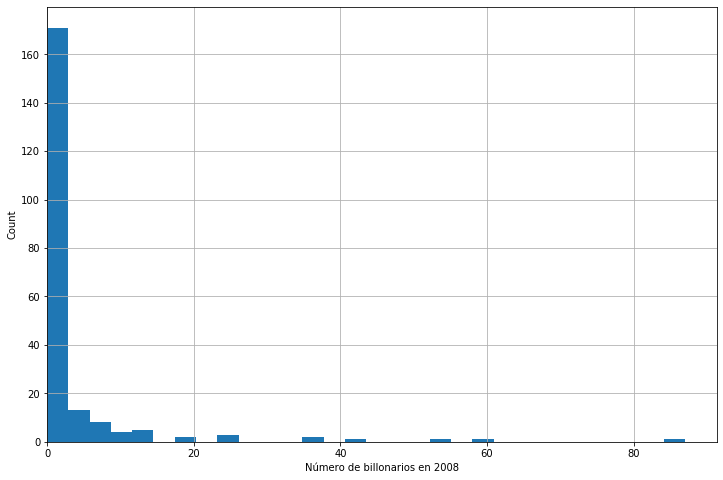

In [21]:
#Histograma de datos:
numbil0_2008 = df[(df['year'] == 2008) & (
    df['country'] != 'United States')].loc[:, 'numbil0']

plt.subplots(figsize=(12, 8))
plt.hist(numbil0_2008, bins=30)
plt.xlim(left=0)
plt.grid()
plt.xlabel('Número de billonarios en 2008')
plt.ylabel('Count')
plt.show()

Códificamos la función de log-verosimilitud asociada a una ditribución Poisson. Crearemos una clase llamada Poisson para que podamos volver a calcular fácilmente los valores de la probabilidad de cada uno de los registros, el gradiente y el hessiano para cada iteración.

In [22]:
class Poisson:

    def __init__(self, y, X, β):
        self.X = X
        self.n, self.k = X.shape
        self.y = y.reshape(self.n,1)
        self.β = β.reshape(self.k,1)

    def μ(self):
        return np.exp(self.X @ self.β)

    def logL(self):
        y = self.y
        μ = self.μ()
        return np.sum(y * np.log(μ) - μ - np.log(factorial(y)))

    def G(self):
        y = self.y
        μ = self.μ()
        return X.T @ (y - μ)

    def H(self):
        X = self.X
        μ = self.μ()
        return -(X.T @ (μ * X))

Construímos la función de Newton-Raphson que permite un modelo como parámetro, a diferencia de la primera función de Newton-Raphson.

In [23]:
def newton_raphson_model(modelo, tolerancia=1e-3, maxiter=1000, display=True):

    i = 0
    error = 100  # Initial error value

    # Print header of output
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"θ":<60}'
        print(header)
        print("-" * len(header))

    while np.any(error > tolerancia) and i < maxiter:
        H, G = modelo.H(), modelo.G()
        β_new = modelo.β - (np.linalg.inv(H) @ G)
        error = β_new - modelo.β
        modelo.β = β_new

        # Print iterations
        if display:
            β_list = [f'{t:.3}' for t in list(modelo.β.flatten())]
            update = f'{i:<13}{modelo.logL():<16.8}{β_list}'
            print(update)

        i += 1

    print(f'Number of iterations: {i}')
    print(f'β_hat = {modelo.β.flatten()}')

    return modelo.β.flatten()

Ahora repliquemos los resultados del artículo de Daniel Treisman, Los multimillonarios de Rusia, mencionado anteriormente en el notebook.

Treisman comienza estimando la ecuación siguiente:

y_i es el número de multimillonarios i

x_i1 es logPIB per cápitai

x_i2 es logpoblacióni

x_i3 son años en GATTi - años de membresía en el GATT y la OMC (para poder acceder a los mercados internacionales)

Nota: Para este ejercicio solamente consideraremos datos del 2008.

In [24]:
# Solamente 2008
df = df[df['year'] == 2008]
# Agregar el intercepto
df['const'] = 1
# Regresiones Poisson.
reg = df[['const','lngdppc', 'lnpop', 'gattwto08', 'numbil0']]

In [25]:
reg.head()

,const,lngdppc,lnpop,gattwto08,numbil0
18,1,10.786021,19.532846,60.0,469.0
44,1,10.743365,17.319439,0.0,25.0
70,1,10.072139,12.760934,0.0,0.0
95,1,10.223734,11.526276,0.0,0.0
120,1,11.446847,11.086334,0.0,0.0


In [26]:
#Imputamos con la media
regf = reg.fillna(reg.mean())

In [27]:
### Separando y de x 
X = regf.iloc[:,[0,1,2,3]]
y = regf.iloc[:,[4]]

In [28]:
#convertimos a numpy
X = X.to_numpy()
y = y.to_numpy()

In [29]:
#Take a guess at initial βs
init_β = np.array([0.1, 0.1, 0.1, 0.1])
#Create an object with Poisson model values
poi = Poisson(y, X, β=init_β)

In [30]:
#Use newton_raphson to find the MLE
β_hat = newton_raphson_model(poi, display=True)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -inf            ['-0.932', '0.102', '0.103', '0.0994']
1            -inf            ['-2.02', '0.108', '0.111', '0.0978']
2            -inf            ['-3.26', '0.124', '0.132', '0.0937']
3            -inf            ['-4.93', '0.166', '0.188', '0.0837']
4            -inf            ['-7.81', '0.267', '0.321', '0.0632']
5            -inf            ['-13.3', '0.476', '0.582', '0.0354']
6            -inf            ['-21.0', '0.759', '0.894', '0.016']
7            -inf            ['-26.4', '0.969', '1.09', '0.00917']
8            -inf            ['-28.5', '1.06', '1.15', '0.00711']
9            -inf            ['-28.7', '1.07', '1.16', '0.00683']
10           -inf            ['-28.7', '1.07', '1.16', '0.00683']
Number of iterations: 11
β_hat = [-2.87359322e+01  1.07004016e+00  1.15985256e+00  6.8

In [31]:
#Probamos con el método de statmodels.
# Keep only year 2008
df2 = df[df['year'] == 2008]
# Add a constant
df2['const'] = 1
# Variable sets
reg2 = ['const', 'lngdppc', 'lnpop', 'gattwto08']
poisson_reg = sm.Poisson(df[['numbil0']], df[reg2],
                         missing='drop').fit(cov_type='HC0')
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Sat, 05 Dec 2020   Pseudo R-squ.:                  0.8574
Time:                        20:30:50   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000     -34.103     -23.997
lngdppc        1.0839      0.